In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

def get_files_in_dir(dir, absolute=True):
    if absolute:
        return [os.path.join(dir, f) for f in os.listdir(dir)]
    else:
        return [f for f in os.listdir(dir)]

def summarize_df(dir_reports):
    df = pd.concat([
        pd.read_csv(os.path.join(dir_reports, 'export_meterto_csv_report_ElectricityFacility_ZoneTimestep.csv')).drop(['Zone Timestep'], axis=1) / 3600000,
        pd.read_csv(os.path.join(dir_reports, 'export_variableto_csv_report_GeneratorProducedDCElectricEnergy_ZoneTimestep.csv')).drop(['Zone Timestep'], axis=1).sum(axis=1) / 3600000,
        pd.read_csv(os.path.join(dir_reports, 'export_variableto_csv_report_FacilityNetPurchasedElectricEnergy_ZoneTimestep.csv')).drop(['Zone Timestep'], axis=1) / 3600000,
    ], axis=1)
    df.columns = ['Consumed kWh', 'Generated kWh', 'Purchased kWh']
    df['Consumed PV kWh'] = np.minimum(df['Generated kWh'], df['Consumed kWh'])
    df['Exported PV kWh'] = np.minimum(df['Purchased kWh'], 0) * -1
    df.index = pd.date_range(start="2006-01-01",end="2007-1-1", freq='10min')[:-1]
    df['Month'] = pd.to_datetime(df.index).month
    df['day_of_year'] = pd.to_datetime(df.index).day_of_year
    df['Year'] = pd.to_datetime(df.index).year
    return df

def get_KPI(df, t_feat='Month'):
    assert t_feat in ['day_of_year', 'Month', 'Year']
    ls_t, ls_ss, ls_sc = [], [], []
    for i, df_t in df.groupby(t_feat):
        ls_t.append(df_t[t_feat].values[0])
        consumed = df_t['Consumed kWh'].sum() # net daily consumption
        pv_generated = df_t['Generated kWh'].sum()
        pv_exported = df_t.loc[df_t['Purchased kWh']<0, 'Generated kWh'].sum()
        pv_consumed = pv_generated - pv_exported
        purchased = df_t.loc[df_t['Purchased kWh']>=0, 'Purchased kWh'].sum()
        ss = pv_consumed/consumed
        sc = pv_consumed/pv_generated
        ls_ss.append(ss)
        ls_sc.append(sc)

    df_kpi = pd.DataFrame({t_feat: ls_t, "Self-Sufficiency": ls_ss, "Self-Consumption": ls_sc})
    df_kpi = df_kpi.set_index(df_kpi[t_feat]).drop([t_feat], axis=1)
    return df_kpi


DIR_REPO = 'D:/GitHub/EnergyFlexibilityOntology'

dir_pv = os.path.join(DIR_REPO, 'example/local_exp/EF_PV_generation/workflows_pv')
dir_pv_pre = os.path.join(DIR_REPO, 'example/local_exp/EF_PV_generation/workflows_pv_pre')
dir_pv_ev = os.path.join(DIR_REPO, 'example/local_exp/EF_PV_generation/workflows_pv_ev')

In [2]:

ls_pv_sims = [os.path.join(p, 'reports') for p in get_files_in_dir(dir_pv)]
ls_pv_pre_sims = [os.path.join(p, 'reports') for p in get_files_in_dir(dir_pv_pre)]
ls_pv_ev_sims = [os.path.join(p, 'reports') for p in get_files_in_dir(dir_pv_ev)]

dict_pv = {}
for p in tqdm(ls_pv_sims):
    clm = p.split('2006-')[1].split('\\')[0]
    # print("==>> clm: ", clm)
    df = summarize_df(p)
    df['Climate'] = clm
    dict_pv[clm] = df

dict_pv_pre = {}
for p in tqdm(ls_pv_pre_sims):
    clm = p.split('2006-')[1].split('\\')[0]
    # print("==>> clm: ", clm)
    df = summarize_df(p)
    df['Climate'] = clm
    dict_pv_pre[clm] = df
    
    
dict_pv_ev = {}
for p in tqdm(ls_pv_ev_sims):
    clm = p.split('2006-')[1].split('\\')[0]
    # print("==>> clm: ", clm)
    df = summarize_df(p)
    df['Climate'] = clm
    dict_pv_ev[clm] = df

100%|██████████| 15/15 [00:10<00:00,  1.50it/s]


In [27]:
df_pv = pd.read_csv('D:/GitHub/EnergyFlexibilityOntology/example/local_exp/EF_PV_generation/workflows_pv/ASHRAE 169-2006-2A/reports/export_meterto_csv_report_ElectricityFacility_ZoneTimestep.csv')
df_pv_ev = pd.read_csv('D:/GitHub/EnergyFlexibilityOntology/example/local_exp/EF_PV_generation/workflows_pv_ev/ASHRAE 169-2006-2A/reports/export_meterto_csv_report_ElectricityFacility_ZoneTimestep.csv')

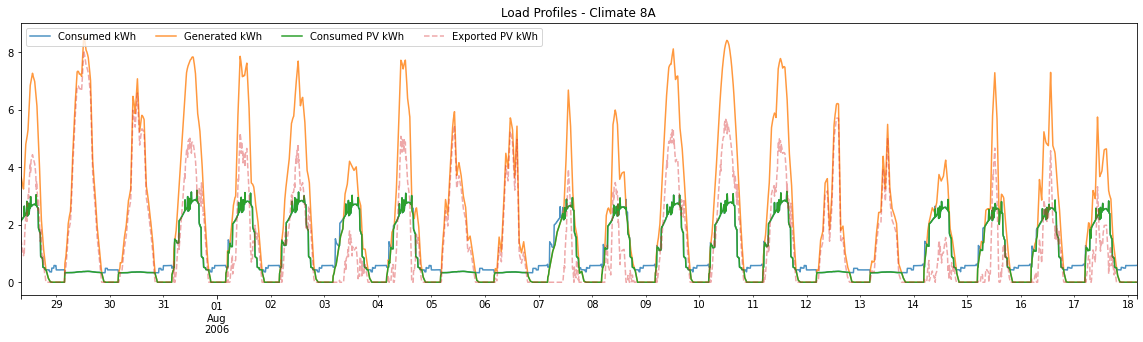

In [13]:
df_ev = summarize_df(ls_pv_ev_sims[0])
clm = '8A'
df_ev = dict_pv_ev[clm]

f, ax = plt.subplots(1, 1, figsize=(20, 5))
df_ev['Consumed PV kWh'] = np.minimum(df_ev['Generated kWh'], df_ev['Consumed kWh'])
# Winter
# df_ev.iloc[1000:3000, :]['Consumed kWh'].plot(ax=ax, label='Consumed kWh', alpha=0.8)
# df_ev.iloc[1000:3000, :]['Generated kWh'].plot(ax=ax, label='Generated kWh', alpha=0.8)
# df_ev.iloc[1000:3000, :]['Consumed PV kWh'].plot(ax=ax, label='Consumed PV kWh', alpha=1)
# df_ev.iloc[1000:3000, :]['Exported PV kWh'].plot(ax=ax, label='Exported PV kWh', alpha=0.4, style='--')

# Summer
df_ev.iloc[30000:33000, :]['Consumed kWh'].plot(ax=ax, label='Consumed kWh', alpha=0.8)
df_ev.iloc[30000:33000, :]['Generated kWh'].plot(ax=ax, label='Generated kWh', alpha=0.8)
df_ev.iloc[30000:33000, :]['Consumed PV kWh'].plot(ax=ax, label='Consumed PV kWh', alpha=1)
df_ev.iloc[30000:33000, :]['Exported PV kWh'].plot(ax=ax, label='Exported PV kWh', alpha=0.4, style='--')
plt.title(f'Load Profiles - Climate {clm}')
plt.legend(loc='best', ncol=4)

plt.savefig(f'Load Profiles_{clm}.png', dpi=300, bbox_inches='tight')

In [92]:
# ----------------------------------- KPIs ----------------------------------- #
# PV only
ls_monthly_ss_pv, ls_monthly_sc_pv = [], []
ls_daily_ss_pv, ls_daily_sc_pv = [], []
for clm, df in dict_pv.items():
    monthly_kpi = get_KPI(df, t_feat='Month')
    daily_kpi = get_KPI(df, t_feat='day_of_year')
    ls_monthly_ss_pv.append(monthly_kpi['Self-Sufficiency'].values)
    ls_monthly_sc_pv.append(monthly_kpi['Self-Consumption'].values)
    ls_daily_ss_pv.append(daily_kpi['Self-Sufficiency'].values)
    ls_daily_sc_pv.append(daily_kpi['Self-Consumption'].values)

ls_monthly_ss_pv = np.array(ls_monthly_ss_pv)
ls_monthly_sc_pv = np.array(ls_monthly_sc_pv)
ls_daily_ss_pv = np.array(ls_daily_ss_pv)
ls_daily_sc_pv = np.array(ls_daily_sc_pv)

# PV + pre-conditioning
ls_monthly_ss_pv_pre, ls_monthly_sc_pv_pre = [], []
ls_daily_ss_pv_pre, ls_daily_sc_pv_pre = [], []
for clm, df in dict_pv_pre.items():
    monthly_kpi = get_KPI(df, t_feat='Month')
    daily_kpi = get_KPI(df, t_feat='day_of_year')
    ls_monthly_ss_pv_pre.append(monthly_kpi['Self-Sufficiency'].values)
    ls_monthly_sc_pv_pre.append(monthly_kpi['Self-Consumption'].values)
    ls_daily_ss_pv_pre.append(daily_kpi['Self-Sufficiency'].values)
    ls_daily_sc_pv_pre.append(daily_kpi['Self-Consumption'].values)

ls_monthly_ss_pv_pre = np.array(ls_monthly_ss_pv_pre)
ls_monthly_sc_pv_pre = np.array(ls_monthly_sc_pv_pre)
ls_daily_ss_pv_pre = np.array(ls_daily_ss_pv_pre)
ls_daily_sc_pv_pre = np.array(ls_daily_sc_pv_pre)


# PV + EV
ls_monthly_ss_pv_ev, ls_monthly_sc_pv_ev = [], []
ls_daily_ss_pv_ev, ls_daily_sc_pv_ev = [], []
for clm, df in dict_pv_ev.items():
    monthly_kpi = get_KPI(df, t_feat='Month')
    daily_kpi = get_KPI(df, t_feat='day_of_year')
    ls_monthly_ss_pv_ev.append(monthly_kpi['Self-Sufficiency'].values)
    ls_monthly_sc_pv_ev.append(monthly_kpi['Self-Consumption'].values)
    ls_daily_ss_pv_ev.append(daily_kpi['Self-Sufficiency'].values)
    ls_daily_sc_pv_ev.append(daily_kpi['Self-Consumption'].values)

ls_monthly_ss_pv_ev = np.array(ls_monthly_ss_pv_ev)
ls_monthly_sc_pv_ev = np.array(ls_monthly_sc_pv_ev)
ls_daily_ss_pv_ev = np.array(ls_daily_ss_pv_ev)
ls_daily_sc_pv_ev = np.array(ls_daily_sc_pv_ev)


<BarContainer object of 12 artists>

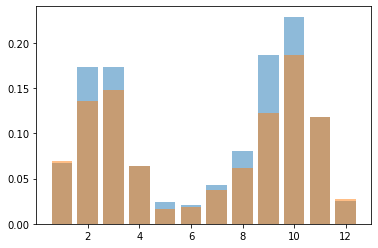

In [109]:
clm_i = 14
plt.bar(x=np.arange(1, 13), height=ls_monthly_ss_pv_ev[clm_i], alpha=0.5)
plt.bar(x=np.arange(1, 13), height=ls_monthly_ss_pv[clm_i], alpha=0.5)

C:\Users\hanli\Miniconda3\envs\sdi\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


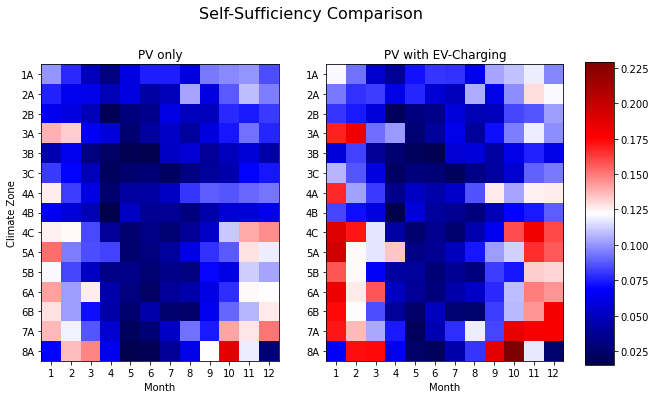

In [143]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

minmin = np.min([np.min(ls_monthly_ss_pv), np.min(ls_monthly_ss_pv_ev)])
maxmax = np.max([np.max(ls_monthly_ss_pv), np.max(ls_monthly_ss_pv_ev)])

im_1 = axs[0].imshow(ls_monthly_ss_pv, vmin=minmin, vmax=maxmax, cmap='seismic')
im_2 = axs[1].imshow(ls_monthly_ss_pv_ev, vmin=minmin, vmax=maxmax, cmap='seismic')
clms = list(dict_pv_pre.keys())
months = np.arange(1, 13)
axs[0].set_xticks(np.arange(len(months)), labels=months)
axs[1].set_xticks(np.arange(len(months)), labels=months)
axs[0].set_yticks(np.arange(len(clms)), labels=clms)
axs[1].set_yticks(np.arange(len(clms)), labels=clms)

axs[0].set_xlabel('Month')
axs[1].set_xlabel('Month')
axs[0].set_ylabel('Climate Zone')

axs[0].set_title('PV only')
axs[1].set_title('PV with EV-Charging')


fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(im_2, cax=cbar_ax)

fig.suptitle('Self-Sufficiency Comparison', size=16)
fig.show()

fig.savefig('Self-Sufficiency Comparison_1.png', dpi=300, bbox_inches='tight')

C:\Users\hanli\Miniconda3\envs\sdi\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


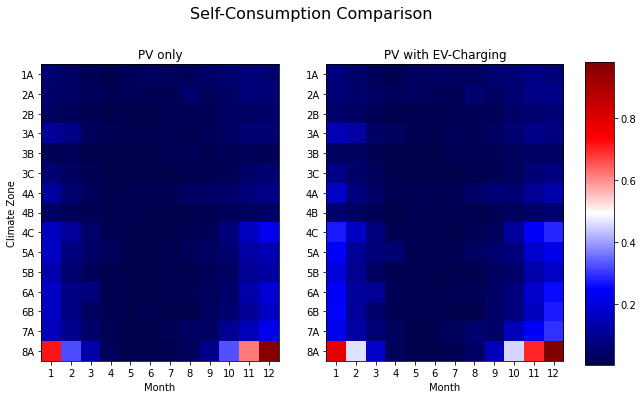

In [144]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

minmin = np.min([np.min(ls_monthly_sc_pv), np.min(ls_monthly_sc_pv_ev)])
maxmax = np.max([np.max(ls_monthly_sc_pv), np.max(ls_monthly_sc_pv_ev)])

im_1 = axs[0].imshow(ls_monthly_sc_pv, vmin=minmin, vmax=maxmax, cmap='seismic')
im_2 = axs[1].imshow(ls_monthly_sc_pv_ev, vmin=minmin, vmax=maxmax, cmap='seismic')
clms = list(dict_pv_pre.keys())
months = np.arange(1, 13)
axs[0].set_xticks(np.arange(len(months)), labels=months)
axs[1].set_xticks(np.arange(len(months)), labels=months)
axs[0].set_yticks(np.arange(len(clms)), labels=clms)
axs[1].set_yticks(np.arange(len(clms)), labels=clms)

axs[0].set_xlabel('Month')
axs[1].set_xlabel('Month')
axs[0].set_ylabel('Climate Zone')

axs[0].set_title('PV only')
axs[1].set_title('PV with EV-Charging')

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(im_2, cax=cbar_ax)

fig.suptitle('Self-Consumption Comparison', size=16)
fig.show()
fig.savefig('Self-Consumption Comparison_1.png', dpi=300, bbox_inches='tight')

Text(0, 0.5, 'Climate Zone')

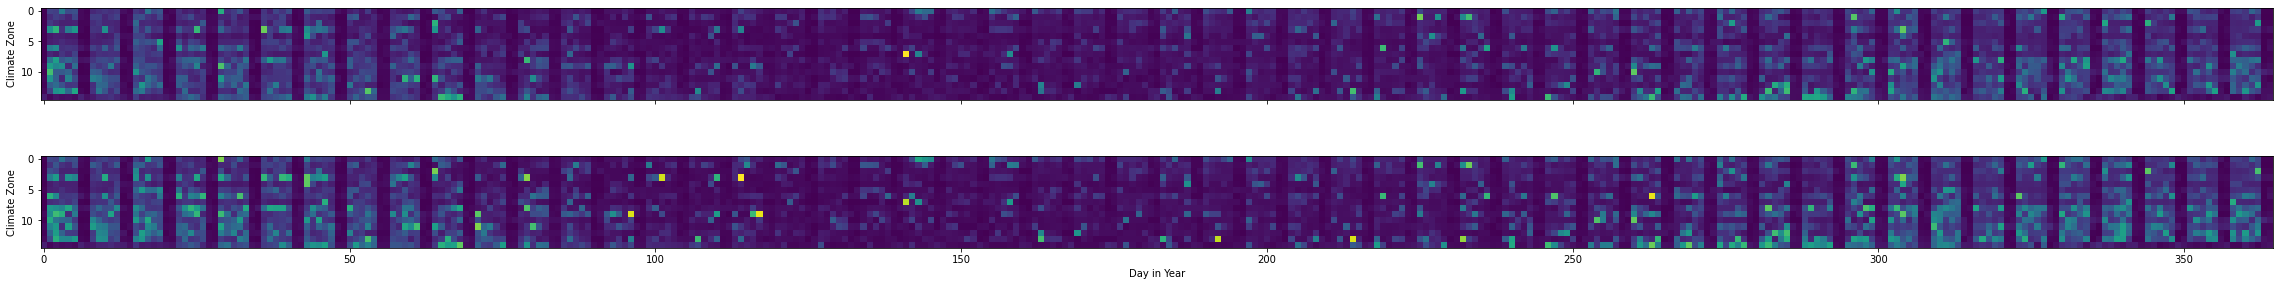

In [133]:
fig, axs = plt.subplots(2, 1, figsize=(40, 5), sharex=True)
im = axs[0].imshow(ls_daily_ss_pv)
im = axs[1].imshow(ls_daily_ss_pv_ev)
axs[1].set_xlabel('Day in Year')
axs[0].set_ylabel('Climate Zone')
axs[1].set_ylabel('Climate Zone')

Text(0, 0.5, 'Climate Zone')

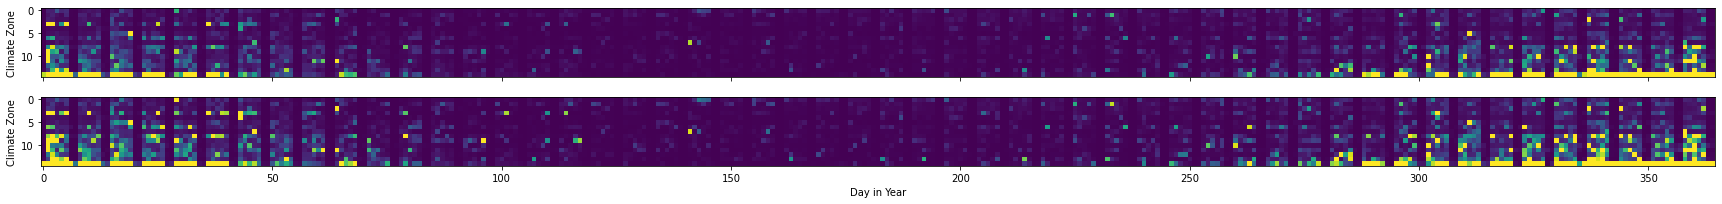

In [132]:
fig, axs = plt.subplots(2, 1, figsize=(30, 3), sharex=True)
im = axs[0].imshow(ls_daily_sc_pv)
im = axs[1].imshow(ls_daily_sc_pv_ev)
axs[1].set_xlabel('Day in Year')
axs[0].set_ylabel('Climate Zone')
axs[1].set_ylabel('Climate Zone')